In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#InceptionV3 is deep learning model for image classification
from tensorflow.keras.applications.inception_v3 import InceptionV3

#layers in deep learning models.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

#The Model class is used to create and manipulate deep learning models.
from tensorflow.keras.models import Model

#Adam is an optimization algorithm commonly used for training deep learning models.
from tensorflow.keras.optimizers import Adam

#They provide functions for loading and preprocessing images to be used as input to deep learning models.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
#load images from the directory
data_dir = 'Dataset\Signs'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 658 files belonging to 11 classes.


In [3]:
#generate image data
#split the dataset with 80% used for training and 20% for validation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

In [4]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [5]:
#training the data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

#validate
val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 522 images belonging to 11 classes.
Found 124 images belonging to 11 classes.


In [6]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 11 ....


In [7]:
import matplotlib.pyplot as plt

def show_img(data):
    plt.figure(figsize=(15, 15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"), aspect='auto')
            ax.axis("off")
    plt.show

In [8]:
from PIL import Image
import os

data_dir = 'Dataset\Signs'

# Iterate over each image in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.gif') or filename.endswith('.bmp'):
        # Open the image using PIL
        image = Image.open(os.path.join(data_dir, filename))
        
        # Convert the image to JPEG format
        image = image.convert('RGB')
        
        # Save the image in JPEG format
        new_filename = os.path.splitext(filename)[0] + '.jpg'
        image.save(os.path.join(image_dir, new_filename))

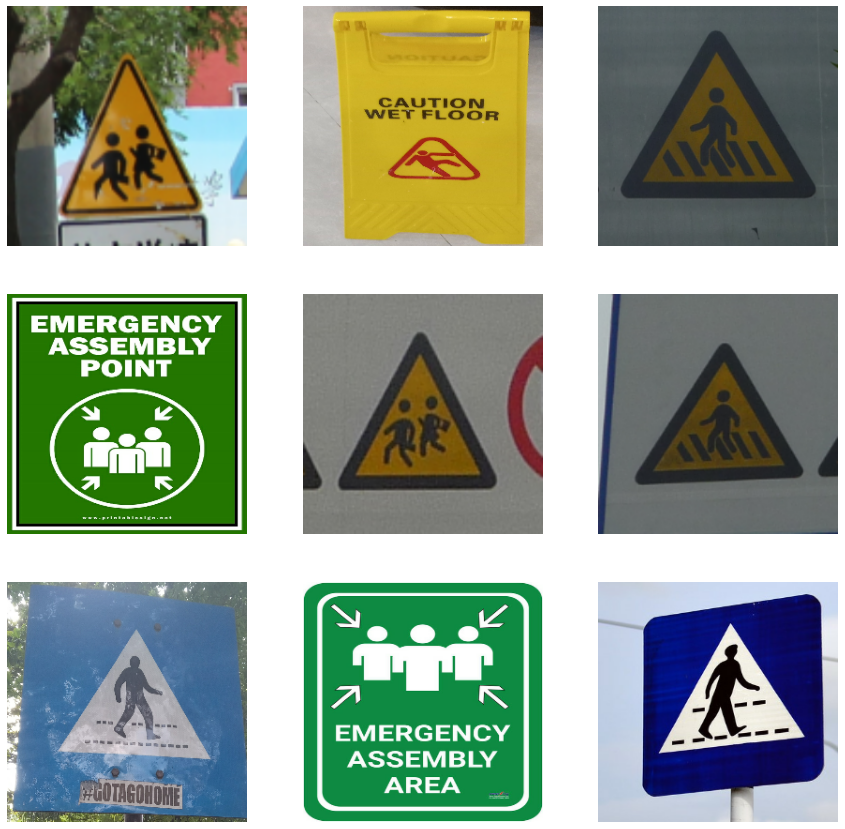

In [9]:
#show images
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(17):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

show_img(data)

In [10]:
#train the InceptionV3 model
#loading pre-trained weights and freezing the layers
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

In [11]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

#adds additional layers to the pre-trained InceptionV3 model and compiles the new model for training.
x = pre_trained.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define custom metrics
precision = Precision(name='precision')
recall = Recall(name='recall')

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + 1e-10))

model = Model(inputs=pre_trained.input, outputs=predictions)

# Compile the model with custom metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision, recall, f1_score]
)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 26, 26, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 26, 26, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 26, 26, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 26, 26, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 26, 26, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 26, 26, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 26, 26, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 26, 26, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [16]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 10,
                    verbose = 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11840\213251588.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


Epoch 1/10
16/16 [==============================] - 35s 2s/step - loss: 0.1540 - accuracy: 0.9592 - precision: 0.9611 - recall: 0.9592 - f1_score: 0.9540 - val_loss: 0.1018 - val_accuracy: 0.9792 - val_precision: 0.9792 - val_recall: 0.9792 - val_f1_score: 0.9878
Epoch 2/10
16/16 [==============================] - 34s 2s/step - loss: 0.1192 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9735 - f1_score: 0.9733 - val_loss: 0.1277 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688 - val_f1_score: 0.9792
Epoch 3/10
16/16 [==============================] - 35s 2s/step - loss: 0.1044 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - f1_score: 0.9764 - val_loss: 0.0916 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583 - val_f1_score: 0.9392
Epoch 4/10
16/16 [==============================] - 36s 2s/step - loss: 0.1972 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - f1_score: 0.9695 - val_loss: 0.3517 - val_accuracy: 0.9375 - val_precis

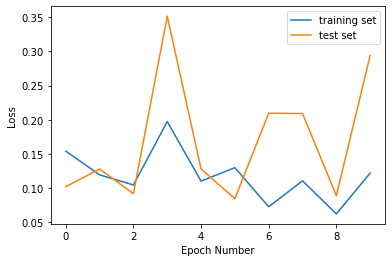

In [17]:
#LOSS
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

In [18]:
final_train_Loss = round(history.history['loss'][-1] * 100)
final_test_Loss = round(history.history['val_loss'][-1] * 100)

print("Final Training Loss:", final_train_Loss, "%")
print("Final Test Loss:", final_test_Loss, "%")

Final Training Loss: 12 %
Final Test Loss: 29 %


In [19]:
final_train_loss = history.history['loss'][-1]
final_test_loss = history.history['val_loss'][-1]

print("Final Training Loss:", final_train_loss)
print("Final Test Loss:", final_test_loss)

Final Training Loss: 0.12180095165967941
Final Test Loss: 0.29413971304893494


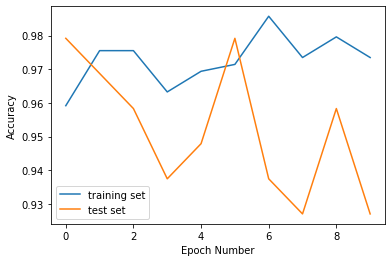

In [20]:
#Accuracy
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [21]:
final_train_accuracy = history.history['accuracy'][-1]
final_test_accuracy = history.history['val_accuracy'][-1]

print("Final Training Accuracy:", final_train_accuracy)
print("Final Test Accuracy:", final_test_accuracy)

Final Training Accuracy: 0.9734693765640259
Final Test Accuracy: 0.9270833134651184


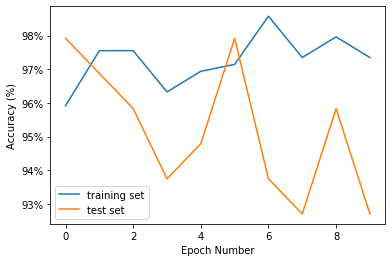

In [22]:
import matplotlib.pyplot as plt

# Your code to create the plot and add data
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')  # Update the y-axis label

# Convert accuracy values to percentages
train_accuracy_percent = [acc * 100 for acc in history.history['accuracy']]
test_accuracy_percent = [acc * 100 for acc in history.history['val_accuracy']]

plt.plot(train_accuracy_percent, label='training set')
plt.plot(test_accuracy_percent, label='test set')

# Set y-axis ticks as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.legend()
plt.show()


In [23]:
final_train_accuracy = round(history.history['accuracy'][-1] * 100)
final_test_accuracy = round(history.history['val_accuracy'][-1] * 100)

print("Final Training Accuracy:", final_train_accuracy, "%")
print("Final Test Accuracy:", final_test_accuracy, "%")

Final Training Accuracy: 97 %
Final Test Accuracy: 93 %


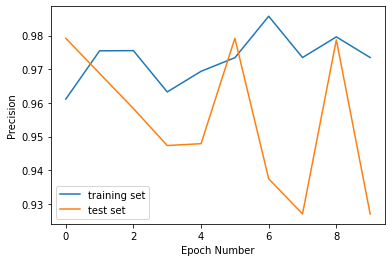

In [24]:
#Precision
plt.xlabel('Epoch Number')
plt.ylabel('Precision')
plt.plot(history.history['precision'], label='training set')
plt.plot(history.history['val_precision'], label='test set')
plt.legend()
plt.show()


In [25]:
final_train_precision = round(history.history['precision'][-1] * 100)
final_test_precision = round(history.history['val_precision'][-1] * 100)

print("Final Training Precision:", final_train_precision, "%")
print("Final Test Precision:", final_test_precision, "%")

Final Training Precision: 97 %
Final Test Precision: 93 %


In [26]:
final_train_precision = history.history['precision'][-1]
final_test_precision = history.history['val_precision'][-1]

print("Final Training Precision:", final_train_precision)
print("Final Test Precision:", final_test_precision)

Final Training Precision: 0.9734693765640259
Final Test Precision: 0.9270833134651184


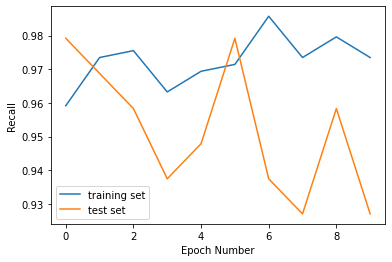

In [27]:
#Recall
plt.xlabel('Epoch Number')
plt.ylabel('Recall')
plt.plot(history.history['recall'], label='training set')
plt.plot(history.history['val_recall'], label='test set')
plt.legend()
plt.show()

In [28]:
final_train_recall = round(history.history['recall'][-1] * 100)
final_test_recall  = round(history.history['val_recall'][-1] * 100)

print("Final Training Recall :", final_train_recall, "%")
print("Final Test Recall :", final_test_recall, "%")

Final Training Recall : 97 %
Final Test Recall : 93 %


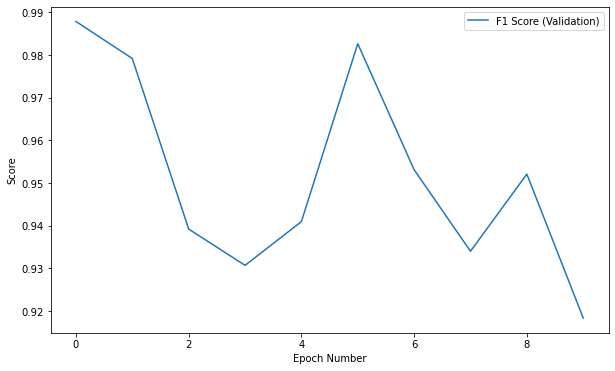

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.xlabel('Epoch Number')
plt.ylabel('Score')
plt.plot(history.history['val_f1_score'], label='F1 Score (Validation)')
plt.legend()
plt.show()

In [30]:
f1_score_train = 2 * (final_train_precision * final_train_recall) / (final_train_precision + final_train_recall)
f1_score_test = 2 * (final_test_precision * final_test_recall) / (final_test_precision + final_test_recall)

print("F1 Train Score:", f1_score_train)
print("F1 Test Score:", f1_score_test)


F1 Train Score: 1.9275938706177538
F1 Test Score: 1.8358655482682478


In [31]:
model_name = 'Road_Sign_Identification.h5'
model.save(model_name, save_format='h5')

In [32]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [35]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    prob = prediction
    print(prob[0])
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [39]:
import tensorflow as tf
import tensorflow_hub as hub

# Define the custom metric function f1_score
def f1_score(y_true, y_pred):
    # Your implementation of f1_score here
    pass

# Load the model with custom objects
custom_objects = {'KerasLayer': hub.KerasLayer, 'f1_score': f1_score}
check_model = tf.keras.models.load_model(
    'Road_Sign_Identification.h5',
    custom_objects=custom_objects
)


1/1 [==============================] - 3s 3s/step
[9.9999976e-01 2.6109395e-09 4.7066250e-11 4.5798852e-13 5.5755491e-12
 5.5611925e-11 6.1536227e-08 8.1333074e-12 9.2934386e-08 7.4979857e-12
 1.3087486e-11]


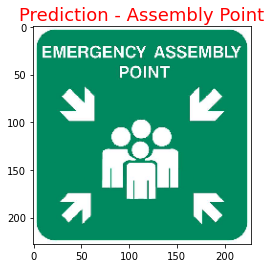

In [40]:
predict_image('Dataset/Signs/Assembly Point/EMERGENCY-ASSEMBLY-POINT-SAFETY-SIGN.jpg', check_model)

1/1 [==============================] - 0s 142ms/step
[6.2362571e-10 1.0000000e+00 3.1026930e-12 2.0006707e-13 2.2864869e-08
 2.0777997e-12 9.7925250e-09 7.8627377e-13 1.5803967e-15 3.2317087e-09
 3.8525196e-09]


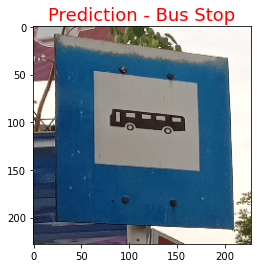

In [41]:
predict_image('Dataset/Signs/Bus Stop/20230510_171700324.jpg', check_model)

1/1 [==============================] - 0s 141ms/step
[8.15731543e-13 6.14584194e-15 4.37068474e-03 9.95629311e-01
 6.12627379e-15 4.22886726e-10 3.87724602e-10 1.39196795e-14
 1.50370612e-12 2.36269104e-15 4.14947075e-14]


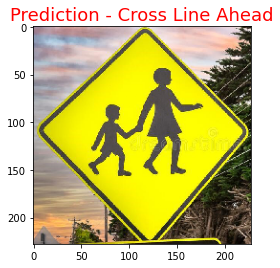

In [42]:
predict_image('Dataset/Signs/Children cross line/school-crossing-sign-street-children-road-next-to-234682143.jpg', check_model)

1/1 [==============================] - 0s 115ms/step
[1.4088976e-15 8.3943466e-17 6.2253648e-08 9.9999988e-01 1.6368610e-08
 6.9865825e-13 5.5507019e-11 1.1482755e-12 4.1719711e-11 6.2986893e-11
 1.4730089e-13]


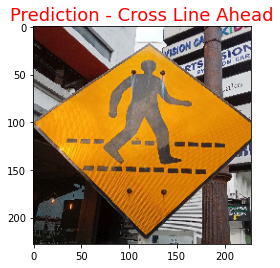

In [43]:
predict_image('Dataset/Signs/Cross Line Ahead/20230510_171407870.jpg', check_model)

1/1 [==============================] - 0s 124ms/step
[1.2773929e-08 2.2010727e-10 5.2870778e-08 1.0186763e-04 9.7658348e-01
 2.6059040e-06 2.3309750e-02 1.5639458e-06 3.2791025e-09 6.8923987e-07
 7.0756373e-11]


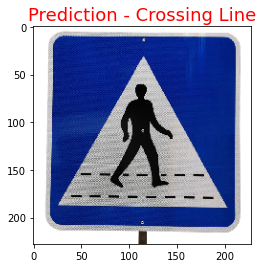

In [44]:
predict_image('Dataset/Signs/Crossing line/Pedestrian-Crossing-Signage.jpg', check_model)

1/1 [==============================] - 0s 118ms/step
[2.82377489e-11 1.10701379e-10 6.23736224e-14 1.50063902e-12
 2.29914896e-14 6.03162919e-13 6.24194829e-09 2.36891832e-13
 5.13055310e-12 1.00000000e+00 1.27870304e-14]


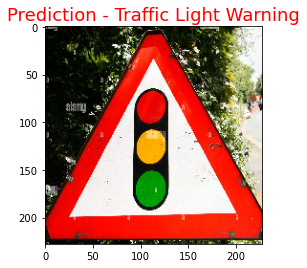

In [45]:
predict_image('Dataset/Signs/Traffic Light Warning/traffic-lights-ahead-road-sign-warning-worcester-worcestershire-england-E6DNPM.jpg', check_model)

1/1 [==============================] - 0s 136ms/step
[1.1344973e-16 1.4232762e-17 5.2149881e-19 1.2161038e-11 2.5933275e-15
 2.1875106e-08 5.1364718e-14 3.8056644e-15 3.9112263e-20 8.1478566e-16
 1.0000000e+00]


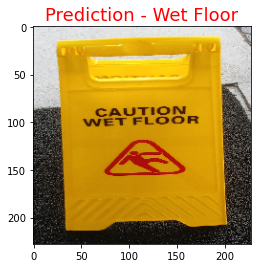

In [46]:
predict_image('Dataset/Signs/Wet Floor/20230502_094038178.jpg', check_model)

In [47]:
classes

['Assembly Point',
 'Bus Stop',
 'Children cross line',
 'Cross Line Ahead',
 'Crossing line',
 'Danger',
 'Hand Wash',
 'Hospital',
 'Traffic Light',
 'Traffic Light Warning',
 'Wet Floor']